In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch, seaborn as sns
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [33]:
n_in = 1
n_h1 = 20
n_h2 = 20
n_out = 2

nn_model1 = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_h2),
                         nn.Tanh(),
                         nn.Linear(n_h2, n_out))
nn_model2 = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))

* Total number of parameters:

In [34]:
print(sum(p.numel() for p in nn_model1.parameters()), sum(p.numel() for p in nn_model2.parameters()))

502 82


#### Generate some random data:

In [35]:
error_sigma = 1e-1
nobs = 1_000
xtrue = torch.randn(nobs, n_in, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, n_out))
ytrue[:,0] = list(abs(xvals)*np.cos(xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(xvals))
ytrue = 3*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()

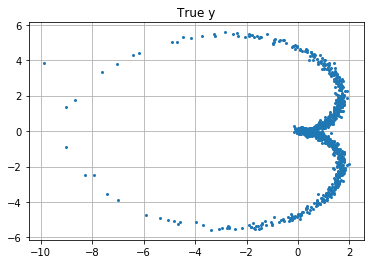

In [36]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

### Optimize given true $x$:

In [37]:
nn_model = copy.deepcopy(nn_model2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)
start = time()
for epoch in range(50_000):
    y_pred = nn_model(xtrue)
    loss = criterion(y_pred, ytrue)
    if (epoch+1)%5_000 == 0 :
        print("Epoch: %d; loss: %.4f; time: %.1f sec" % (epoch+1, loss.item(), time()-start))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
nn_model_optim1 = copy.deepcopy(nn_model)

Epoch: 5000; loss: 0.4637; time: 4.1 sec
Epoch: 10000; loss: 0.1861; time: 8.0 sec
Epoch: 15000; loss: 0.0965; time: 11.9 sec
Epoch: 20000; loss: 0.0646; time: 15.9 sec
Epoch: 25000; loss: 0.0496; time: 19.8 sec
Epoch: 30000; loss: 0.0415; time: 23.7 sec
Epoch: 35000; loss: 0.0364; time: 27.6 sec
Epoch: 40000; loss: 0.0327; time: 31.7 sec
Epoch: 45000; loss: 0.0300; time: 35.8 sec
Epoch: 50000; loss: 0.0279; time: 39.6 sec


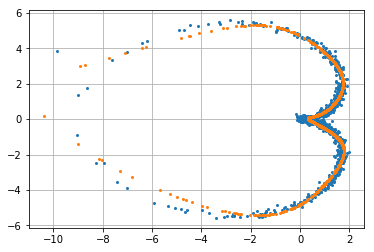

In [38]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.plot(list(y_pred[:,0]), list(y_pred[:,1]), 'o', markersize=2)
plt.grid(True)

### Optimisation for both $x$ and $\theta$:

In [20]:
x = torch.randn(np.shape(xtrue), requires_grad=True)
init_normal(nn_model1), init_normal(nn_model2);

In [21]:
nn_model = copy.deepcopy(nn_model2)

niter = 10**5
lr = 1e-1
rho = 1+2e-6
kappa = 0

start = time()
for epoch in range(niter) :
    loss = nn.MSELoss()(nn_model(x), ytrue)
    loss.backward(retain_graph=True)
    for param in nn_model.parameters() :
        param.data -= lr*param.grad.data + kappa*torch.randn(np.shape(param))
        param.grad.data.zero_()
    x.data -= lr*x.grad.data + kappa*torch.randn(np.shape(x))
    x.grad.data.zero_()
    lr /= rho
    if (epoch+1)%(niter/10) == 0 :
        print("Epoch: %d, loss: %.4f, time: %.1f sec" % (epoch+1, loss, time()-start))

Epoch: 10000, loss: 0.4434, time: 26.2 sec
Epoch: 20000, loss: 0.2717, time: 50.1 sec
Epoch: 30000, loss: 0.2258, time: 73.3 sec
Epoch: 40000, loss: 0.2202, time: 93.0 sec
Epoch: 50000, loss: 0.2127, time: 115.7 sec
Epoch: 60000, loss: 0.2070, time: 140.1 sec
Epoch: 70000, loss: 0.2009, time: 163.9 sec
Epoch: 80000, loss: 0.1814, time: 177.4 sec
Epoch: 90000, loss: 0.1557, time: 202.9 sec
Epoch: 100000, loss: 0.1440, time: 223.2 sec


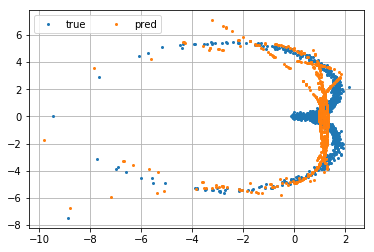

In [22]:
ypred = nn_model(x)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(list(ypred[:,0]), list(ypred[:,1]), 'o', markersize=2, label="pred")
plt.legend(ncol=2)
plt.grid(True)

#### Run it for longer:

In [23]:
niter = 10**6
for epoch in range(niter) :
    loss = nn.MSELoss()(nn_model(x), ytrue)
    loss.backward(retain_graph=True)
    for param in nn_model.parameters() :
        param.data -= lr*param.grad.data + kappa*torch.randn(np.shape(param))
        param.grad.data.zero_()
    x.data -= lr*x.grad.data + kappa*torch.randn(np.shape(x))
    x.grad.data.zero_()
    lr /= rho
    if (epoch+1)%(niter/10) == 0 :
        print("Epoch: %d, loss: %.4f, time: %.1f sec" % (epoch+1, loss, time()-start))

Epoch: 100000, loss: 0.0787, time: 529.9 sec
Epoch: 200000, loss: 0.0633, time: 747.8 sec
Epoch: 300000, loss: 0.0595, time: 967.1 sec
Epoch: 400000, loss: 0.0581, time: 1175.1 sec
Epoch: 500000, loss: 0.0572, time: 1421.6 sec
Epoch: 600000, loss: 0.0567, time: 1612.2 sec
Epoch: 700000, loss: 0.0563, time: 1822.4 sec
Epoch: 800000, loss: 0.0562, time: 2042.1 sec
Epoch: 900000, loss: 0.0560, time: 2261.7 sec
Epoch: 1000000, loss: 0.0560, time: 2480.6 sec


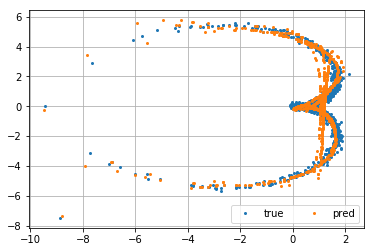

In [24]:
ypred = nn_model(x)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(list(ypred[:,0]), list(ypred[:,1]), 'o', markersize=2, label="pred")
plt.legend(ncol=2)
plt.grid(True)

In [26]:
nn_model_optim2 = copy.deepcopy(nn_model)
x_optim = copy.deepcopy(x)

### Sampling starting at this optimised value:

In [30]:
nn_model, x = copy.deepcopy(nn_model_optim2), copy.deepcopy(x_optim)

In [31]:
prior_sigma = 1e0
my_model = model(x, ytrue, prior_sigma, error_sigma, nn_model)
my_model.update_grad()

In [32]:
T = 5000
int_time = 1e1
delta_leapfrog = 1e-1
n_leapfrog = int(int_time/delta_leapfrog)
M = torch.eye(my_model.n_params())
hmc = HMC(my_model, M, n_leapfrog, delta_leapfrog, T)
hmc.minlf = 20
hmc.run_HMC()

iter    500/5000 after 0.39 min | accept_rate 0.282 | MSE loss 4.671 | stepsize 0.001 | nleapfrog 20
iter   1000/5000 after 0.86 min | accept_rate 0.219 | MSE loss 4.134 | stepsize 0.001 | nleapfrog 20
iter   1500/5000 after 1.27 min | accept_rate 0.163 | MSE loss 4.097 | stepsize 0.001 | nleapfrog 20
iter   2000/5000 after 1.83 min | accept_rate 0.129 | MSE loss 4.111 | stepsize 0.001 | nleapfrog 20
iter   2500/5000 after 2.34 min | accept_rate 0.109 | MSE loss 4.069 | stepsize 0.001 | nleapfrog 20
iter   3000/5000 after 2.75 min | accept_rate 0.095 | MSE loss 4.059 | stepsize 0.001 | nleapfrog 20
iter   3500/5000 after 3.20 min | accept_rate 0.084 | MSE loss 4.060 | stepsize 0.001 | nleapfrog 20
iter   4000/5000 after 3.65 min | accept_rate 0.076 | MSE loss 4.065 | stepsize 0.001 | nleapfrog 20
iter   4500/5000 after 4.04 min | accept_rate 0.070 | MSE loss 4.061 | stepsize 0.001 | nleapfrog 20
iter   5000/5000 after 4.41 min | accept_rate 0.065 | MSE loss 4.057 | stepsize 0.001 | nle

### Sampler starting at true value for $x$ and optimised value for $\theta$:

In [39]:
nn_model = copy.deepcopy(nn_model_optim1)
prior_sigma = 1e0
my_model = model(x, ytrue, prior_sigma, error_sigma, nn_model)
my_model.update_grad()

In [ ]:
T = 5000
int_time = 1e1
delta_leapfrog = 1e-1
n_leapfrog = int(int_time/delta_leapfrog)
M = torch.eye(my_model.n_params())
hmc = HMC(my_model, M, n_leapfrog, delta_leapfrog, T)
hmc.minlf = 20
hmc.run_HMC()

iter    500/5000 after 0.41 min | accept_rate 0.216 | MSE loss 5.016 | stepsize 0.001 | nleapfrog 20
iter   1000/5000 after 0.80 min | accept_rate 0.182 | MSE loss 4.261 | stepsize 0.001 | nleapfrog 20
iter   1500/5000 after 1.17 min | accept_rate 0.146 | MSE loss 4.131 | stepsize 0.001 | nleapfrog 20
iter   2000/5000 after 1.54 min | accept_rate 0.114 | MSE loss 4.118 | stepsize 0.001 | nleapfrog 20
iter   2500/5000 after 1.91 min | accept_rate 0.095 | MSE loss 4.131 | stepsize 0.001 | nleapfrog 20
iter   3000/5000 after 2.28 min | accept_rate 0.083 | MSE loss 4.103 | stepsize 0.001 | nleapfrog 20
iter   3500/5000 after 2.67 min | accept_rate 0.073 | MSE loss 4.089 | stepsize 0.001 | nleapfrog 20


#### This suggests that I messed up the sampler somehow. 

#### ESS's:

### Closest neighbour:

In [32]:
xclosest = torch.zeros(np.shape(x))
for i in trange(nobs) :
    i0 = np.argmin(np.array([torch.norm(ytrue[i]-ypred[j]).data.numpy() for j in range(nobs)]))
    xclosest[i] = x[i0].data

100%|██████████| 1000/1000 [00:11<00:00, 87.84it/s]


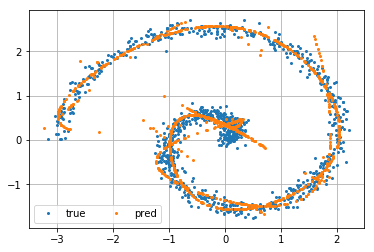

In [34]:
xc = copy.deepcopy(xclosest)
xclosest += 3e-2*torch.randn(np.shape(xclosest))

yclosest = nn_model(xclosest)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(list(yclosest[:,0]), list(yclosest[:,1]), 'o', markersize=2, label="pred")
plt.legend(ncol=2)
plt.grid(True)

In [48]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)
for epoch in range(50_000):
    y_pred = nn_model(xclosest)
    loss = criterion(y_pred, ytrue)
    if (epoch+1)%5_000 == 0 :
        print('epoch: ', epoch+1,' loss: ', loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  5000  loss:  1.57643461227417
epoch:  10000  loss:  1.5395621061325073
epoch:  15000  loss:  1.5195828676223755
epoch:  20000  loss:  1.5073093175888062
epoch:  25000  loss:  1.4994213581085205
epoch:  30000  loss:  1.494264841079712
epoch:  35000  loss:  1.4907609224319458
epoch:  40000  loss:  1.4881879091262817
epoch:  45000  loss:  1.4861202239990234
epoch:  50000  loss:  1.4843045473098755


###  HMC with closest neighbours:

In [39]:
xclosest.requires_grad = True
init_normal(nn_model)

In [40]:
prior_sigma = 1
my_model = model(xclosest, ytrue, prior_sigma, error_sigma, nn_model)
my_model.init_normal()
my_model.update_grad()

In [41]:
T = 500
int_time = 1e1
delta_leapfrog = 1e-2
n_leapfrog = int(int_time/delta_leapfrog)
M = torch.eye(my_model.n_params())
hmc = HMC(my_model, M, n_leapfrog, delta_leapfrog, T)
hmc.minlf = 20

In [42]:
hmc.run_HMC()

iter     50/500 after 0.15 min | accept_rate 0.200 | MSE loss 5.434 | stepsize 0.004 | nleapfrog 20
iter    100/500 after 0.19 min | accept_rate 0.230 | MSE loss 3.561 | stepsize 0.003 | nleapfrog 20
iter    150/500 after 0.22 min | accept_rate 0.213 | MSE loss 3.244 | stepsize 0.002 | nleapfrog 20
iter    200/500 after 0.26 min | accept_rate 0.235 | MSE loss 2.895 | stepsize 0.002 | nleapfrog 20
iter    250/500 after 0.30 min | accept_rate 0.240 | MSE loss 2.493 | stepsize 0.002 | nleapfrog 20
iter    300/500 after 0.33 min | accept_rate 0.220 | MSE loss 2.430 | stepsize 0.002 | nleapfrog 20
iter    350/500 after 0.37 min | accept_rate 0.226 | MSE loss 2.283 | stepsize 0.002 | nleapfrog 20
iter    400/500 after 0.41 min | accept_rate 0.217 | MSE loss 2.101 | stepsize 0.002 | nleapfrog 20
iter    450/500 after 0.44 min | accept_rate 0.213 | MSE loss 1.967 | stepsize 0.002 | nleapfrog 20
iter    500/500 after 0.48 min | accept_rate 0.208 | MSE loss 1.868 | stepsize 0.002 | nleapfrog 20


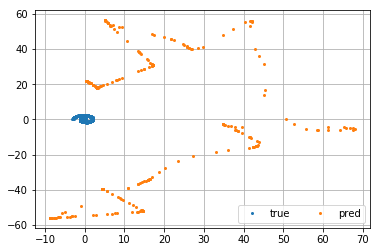

In [43]:
yclosest = nn_model(xclosest)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(list(yclosest[:,0]), list(yclosest[:,1]), 'o', markersize=2, label="pred")
plt.legend(ncol=2)
plt.grid(True)